### 1. INTRO

#### What is GVA?

Gross Value Added (GVA) is a measure of the increase in the value of the economy due to the production of goods and services. It is measured at current basic prices, which include the effect of inflation, excluding taxes (less subsidies) on products (for example, Value Added Tax). GVA plus taxes (less subsidies) on products is equivalent to Gross Domestic Product (GDP).

Regional estimates of GVA are measured using the income approach, which involves adding up the income generated by resident individuals or corporations in the production of goods and services. ([source](http://webarchive.nationalarchives.gov.uk/20160106143511/http://www.ons.gov.uk/ons/dcp171778_388340.pdf))

#### Dataset & goals of the project

The dataset has been downloaded from the [Office for National Statistics website](https://www.ons.gov.uk/economy/grossvalueaddedgva/datasets/regionalgrossvalueaddedincomeapproach) and contains the following data:

* Table 1: Gross Value Added (Income Approach) at current basic prices
* Table 2: Gross Value Added (Income Approach) per head of population at current basic prices
* Table 3: Gross Value Added (Income Approach) per head indices
* Table 4: Growth in Gross Value Added (Income Approach)
* Table 5: Growth in Gross Value Added (Income Approach) per head of population
* Table 6: Gross Value Added (Income Approach) by SIC07 industry at current basic prices
* Table 7: Compensation of Employees (CoE) by SIC07 industry at current basic prices
* Table 8: Mixed Income by SIC07 industry at current basic prices
* Table 9: Rental Income by SIC07 industry at current basic prices
* Table 10: Non-Market Capital Consumption by SIC07 industry at current basic prices
* Table 11: Holding Gains by SIC07 industry at current basic prices
* Table 12: Gross Trading Profits by SIC07 industry at current basic prices
* Table 13: Gross Trading Surplus by SIC07 industry at current basic prices
* Table 14: Taxes on Production by SIC07 industry at current basic prices
* Table 15: Subsidies on Production by SIC07 industry at current basic prices

The goal of the excersise is to analyse how the current basic price for the GVA in Bath and the surrounding area has historically varied, and whether an accurate prediction can be made for future values using a statistical regression.

I plan to use data from tab 1 as a target for my regression model and data from tabs 4 & 7-15 as explanatory features. Data in remaining tabs seem to be somewhat repetitive, only calculated in a different way - so using them would be reduntant and could lead to multicollinearity problems.

### 2. EXPLORATORY DATA ANALYSIS

Initially I wanted to use indicators for every industry for the region however it quickly turned out it's a quite a bit of work to put the data together and would consume a lot of time out of my 6 hours assigned. I decided then to start with a simpler model that uses local totals as the features, to be expanded if it doesn't bring satisfactory results and if time permits.

In [4]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import patsy
import itertools
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV

from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split

sns.set_style('whitegrid')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

#### Reading in the data

In [196]:
data = pd.read_excel("/Users/Mags/Desktop/bath_data.xlsx")
data.head(2)

Name NUTS code  \
0            GVA_Bath     UKK12   
1  Growth_in_GVA_Bath     UKK12   

                                         Region name  1997    1998    1999  \
0  Bath and North East Somerset, North Somerset a...  7985  8521.0  8718.0   
1  Bath and North East Somerset, North Somerset a...     -     6.7     2.3   

     2000     2001     2002     2003   ...        2006     2007   2008   2009  \
0  9312.0  10219.0  10870.0  11945.0   ...     13519.0  14322.0  15042  14745   
1     6.8      9.7      6.4      9.9   ...         2.4      5.9      5     -2   

      2010     2011     2012     2013     2014     2015  
0  15642.0  15816.0  15885.0  16583.0  17630.0  17923.0  
1      6.1      1.1      0.4      4.4      6.3      1.7  

[2 rows x 22 columns]

#### Data cleaning

In [197]:
#dropping unecessary columns:
data = data.drop(["NUTS code", "Region name"], axis=1)
#resetting index:
data = data.set_index(['Name'])
data.index.name = None
data.head()

1997    1998    1999    2000     2001     2002     2003  \
GVA_Bath            7985  8521.0  8718.0  9312.0  10219.0  10870.0  11945.0   
Growth_in_GVA_Bath     -     6.7     2.3     6.8      9.7      6.4      9.9   
CoE_Bath            4128  4456.0  4722.0  5095.0   5760.0   6082.0   6821.0   
Mix_Inc_Bath         459   565.0   585.0   639.0    603.0    634.0    648.0   
Rent_Inc_Bath       1225  1345.0  1416.0  1539.0   1631.0   1688.0   1777.0   

                     2004     2005     2006     2007   2008   2009     2010  \
GVA_Bath            12426  13201.0  13519.0  14322.0  15042  14745  15642.0   
Growth_in_GVA_Bath      4      6.2      2.4      5.9      5     -2      6.1   
CoE_Bath             7121   7640.0   7928.0   8220.0   8506   8704   9041.0   
Mix_Inc_Bath          691    709.0    753.0    725.0    791    751    742.0   
Rent_Inc_Bath        1805   1860.0   1882.0   1989.0   2105   1789   1873.0   

                       2011     2012     2013     2014     2015  
GVA_Bath            15816.0  15885.0  16583.0  17630.0  17923.0  
Growth_in_GVA_Bath      1.1      0.4      4.4      6.3      1.7  
CoE_Bath             9077.0   8972.0   9169.0   9595.0   9819.0  
Mix_Inc_Bath          732.0    857.0    864.0    872.0    895.0  
Rent_Inc_Bath        1957.0   2073.0   2144.0   2278.0   2333.0

In [198]:
#transposing dataframe for easier analysis
data = data.T
data.head()

GVA_Bath Growth_in_GVA_Bath CoE_Bath Mix_Inc_Bath Rent_Inc_Bath  \
1997     7985                  -     4128          459          1225   
1998     8521                6.7     4456          565          1345   
1999     8718                2.3     4722          585          1416   
2000     9312                6.8     5095          639          1539   
2001    10219                9.7     5760          603          1631   

     Cap_Con_Bath Hold_Gains_Bath GTP_Bath GTS_Bath Tax_Bath Subs_Bath  
1997          214              -9     1834       20      121        -7  
1998          209              -6     1804       19      133        -8  
1999          216             -16     1642       22      139        -6  
2000          226             -25     1668       27      155        -6  
2001          254             -23     1796       25      164        -9

In [199]:
#examine the df:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19 entries, 1997 to 2015
Data columns (total 11 columns):
GVA_Bath              19 non-null object
Growth_in_GVA_Bath    19 non-null object
CoE_Bath              19 non-null object
Mix_Inc_Bath          19 non-null object
Rent_Inc_Bath         19 non-null object
Cap_Con_Bath          19 non-null object
Hold_Gains_Bath       19 non-null object
GTP_Bath              19 non-null object
GTS_Bath              19 non-null object
Tax_Bath              19 non-null object
Subs_Bath             19 non-null object
dtypes: object(11)
memory usage: 1.8+ KB


In [200]:
#changing data to numeric:
data = data.apply(pd.to_numeric, errors='coerce')

#### Missing values

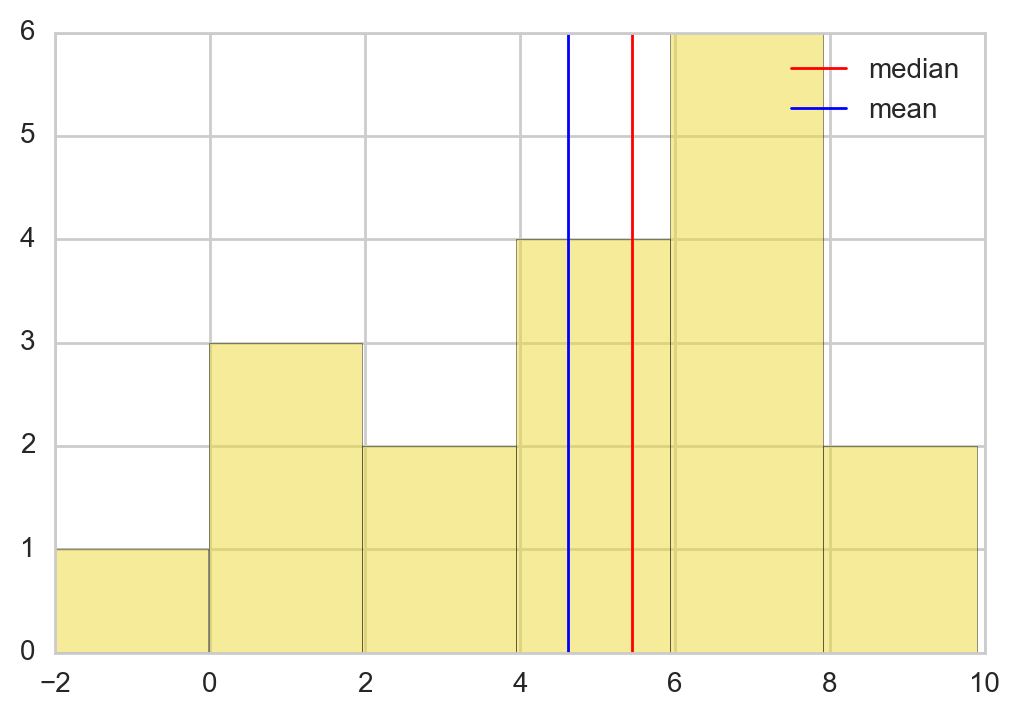

In [201]:
#there is just one missing value in Growth_in_GVA_Bath columns - no data for year 1997. I presume this field is empty because
#we don't have data for 1996, therefore no growth rate could not be calculated, not because it is zero.

#let's set the missing value to Nan and look at distribution of values in this column:

data.replace('-',np.NaN, inplace=True)
s = data.Growth_in_GVA_Bath
s = s.dropna()
plt.hist(s,
         bins=6,
         alpha=0.5,
         color='#EDD834')
plt.axvline(data.Growth_in_GVA_Bath.median(), color='r', linestyle='solid', linewidth=1, label = 'median')
plt.axvline(data.Growth_in_GVA_Bath.mean(), color='b', linestyle='solid', linewidth=1, label = 'mean')
plt.legend()
plt.show()

In [203]:
#Median and mean seem quite close. Our sample size is small and we have just one missing value, so we will 
#replace it with the mean; 
#model-based imputaton seems a bit of overkill in this case.

data.Growth_in_GVA_Bath = data.Growth_in_GVA_Bath.fillna(data.Growth_in_GVA_Bath.mean())

#### Statistical analysis and visualization

In [204]:
#basic statistics:
data.describe()

GVA_Bath  Growth_in_GVA_Bath     CoE_Bath  Mix_Inc_Bath  \
count     19.000000           19.000000    19.000000     19.000000   
mean   13173.894737            4.627778  7413.473684    711.315789   
std     3173.707487            3.059740  1861.927954    116.358666   
min     7985.000000           -2.000000  4128.000000    459.000000   
25%    10544.500000            2.350000  5921.000000    636.500000   
50%    13519.000000            5.000000  7928.000000    725.000000   
75%    15729.000000            6.350000  9006.500000    772.000000   
max    17923.000000            9.900000  9819.000000    895.000000   

       Rent_Inc_Bath  Cap_Con_Bath  Hold_Gains_Bath     GTP_Bath   GTS_Bath  \
count      19.000000     19.000000        19.000000    19.000000  19.000000   
mean     1826.789474    347.315789       -30.894737  2721.473684  31.473684   
std       303.301936     99.671713        19.436205   841.099107  10.259784   
min      1225.000000    209.000000       -73.000000  1642.000000  19.000000   
25%      1659.500000    260.500000       -46.500000  1930.500000  25.000000   
50%      1860.000000    354.000000       -25.000000  2573.000000  28.000000   
75%      2031.000000    435.000000       -15.000000  3345.000000  38.500000   
max      2333.000000    487.000000        -6.000000  4281.000000  53.000000   

         Tax_Bath  Subs_Bath  
count   19.000000  19.000000  
mean   201.842105 -29.736842  
std     49.233303  18.214287  
min    121.000000 -49.000000  
25%    168.000000 -46.000000  
50%    198.000000 -39.000000  
75%    247.000000 -10.500000  
max    280.000000  -6.000000

In the above table we can see that the columns we have in the dataset differ very signifiantly when it comes to the magnitude. As I intend to run linear regression, for better interpretability of the results and also to make visualization easier, I'm going to standardize the numbers.

In [210]:
#standariation
standard = StandardScaler()
standard.fit(data)
stand_data = pd.DataFrame(standard.transform(data),columns=data.columns)
stand_data.index = data.index
stand_data.head()

GVA_Bath  Growth_in_GVA_Bath  CoE_Bath  Mix_Inc_Bath  Rent_Inc_Bath  \
1997 -1.679765            0.000000 -1.812908     -2.227852      -2.038496   
1998 -1.506249            0.695813 -1.631919     -1.291912      -1.632009   
1999 -1.442476           -0.781623 -1.485141     -1.115320      -1.391505   
2000 -1.250184            0.729391 -1.279322     -0.638521      -0.974856   
2001 -0.956568            1.703156 -0.912378     -0.956387      -0.663216   

      Cap_Con_Bath  Hold_Gains_Bath  GTP_Bath  GTS_Bath  Tax_Bath  Subs_Bath  
1997     -1.374201         1.157361 -1.084049 -1.148961 -1.687016   1.282503  
1998     -1.425740         1.315942 -1.120694 -1.249100 -1.436600   1.226097  
1999     -1.353585         0.787339 -1.318577 -0.948683 -1.311391   1.338910  
2000     -1.250507         0.311597 -1.286818 -0.447989 -0.977503   1.338910  
2001     -0.961886         0.417318 -1.130466 -0.648267 -0.789690   1.169691

#### Plotting the features

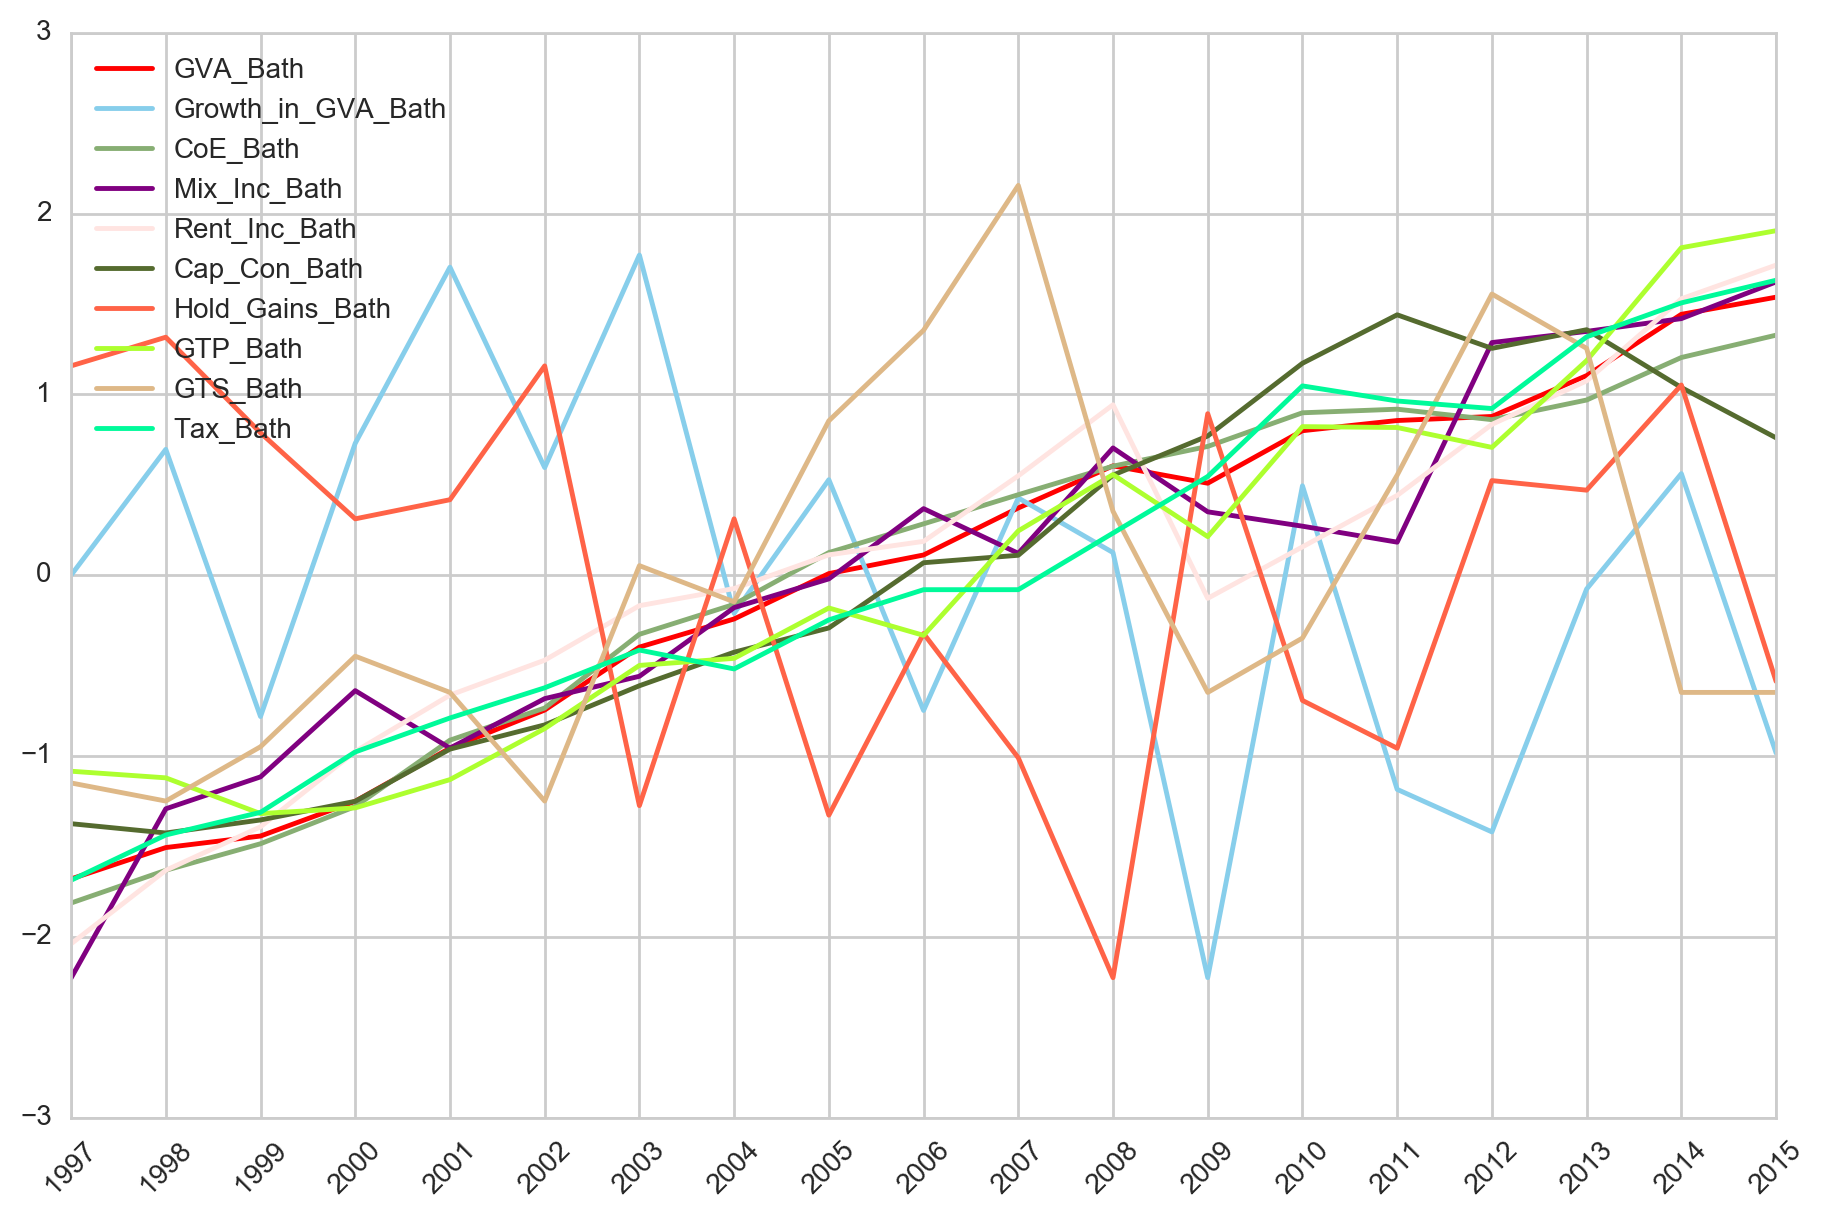

In [244]:
cols = stand_data.columns.tolist()
colours = ['red','skyblue', 'sage', 'purple', 'mistyrose', 'darkolivegreen',
            'tomato', 'greenyellow', 'burlywood', 'mediumspringgreen']

plt.figure(figsize = (11, 7))
#plt.plot(stand_data.index, stand_data.GVA_Bath, lw =4.5, c='#AD2C5F')
for column, colour in zip(cols, colours):
    plt.plot(stand_data.index, stand_data[column], c= colour)

plt.xlim(1997,2015)
plt.xticks(stand_data.index.tolist(), rotation=45)
plt.legend(cols, loc='upper left')
plt.cm.nipy_spectral
plt.show()
    

From the above chart we can see that some features (for example CoE - Compensation of Employees) behave similarly to GVA and they could potentially serve as good predictors for future fluctuations in GVA levels.

To see how well the features correlate let's build heatmap:

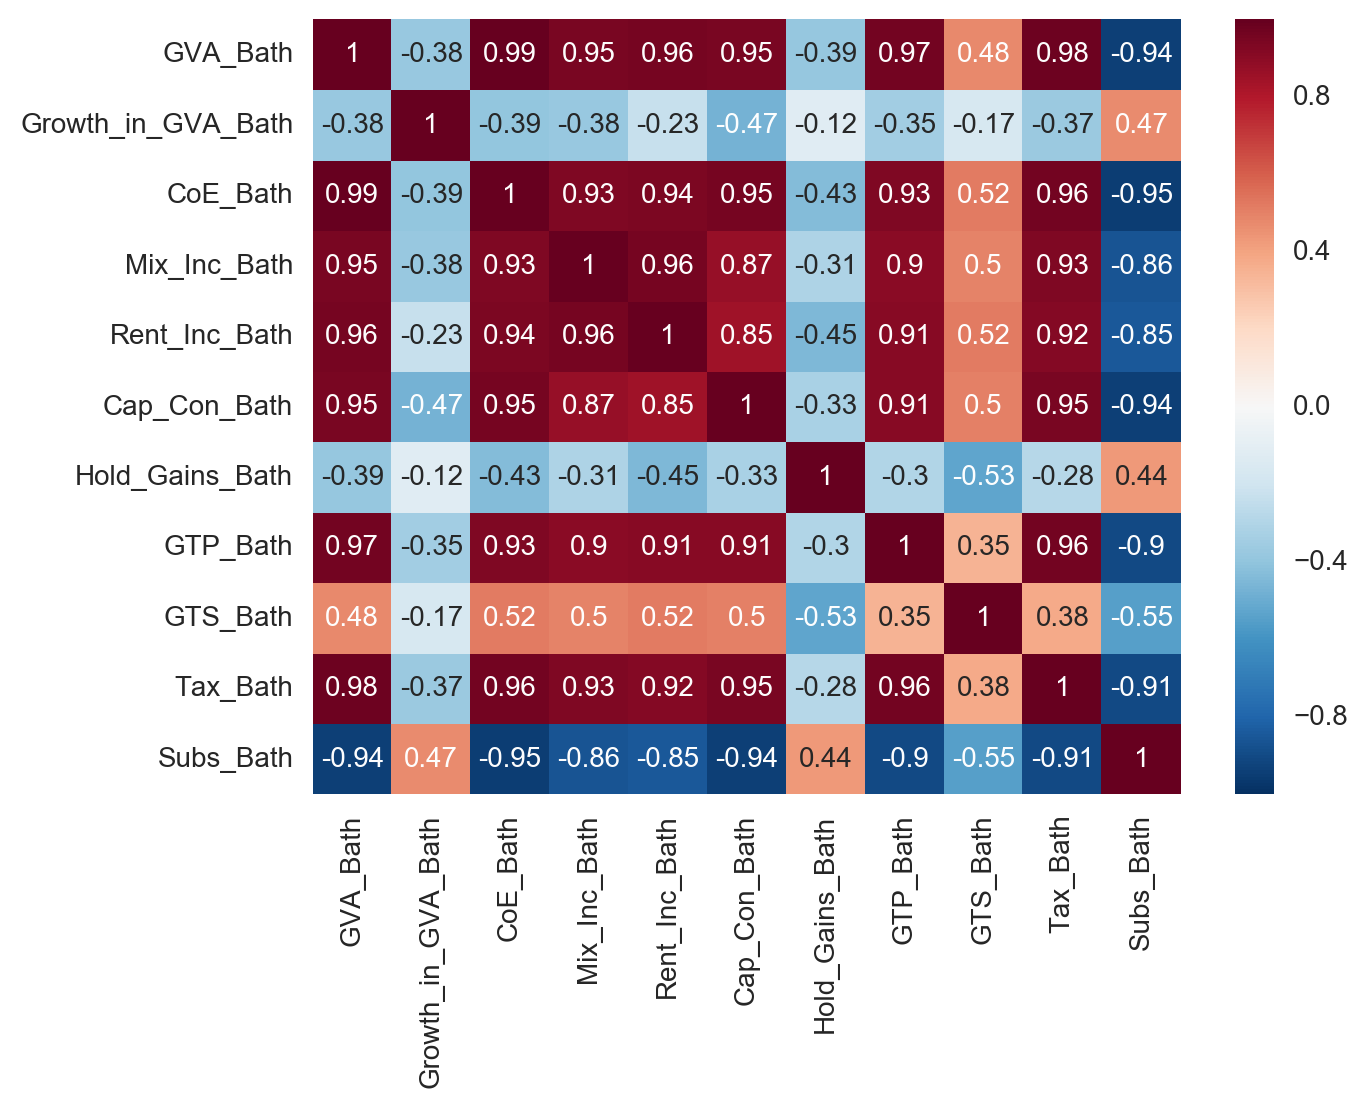

In [246]:
plt.figure(figsize = (7, 5))
sns.heatmap(stand_data.ix[:,'GVA_Bath':].corr(), annot = stand_data.ix[:,'GVA_Bath':].corr())
plt.show()

Wow, these are some very high correlation coefficients! I presumed the variables I'm using are exogenous in a sense that they are not derived from each other but perhaps I was wrong. CoE seems to be particularly well correlated with other features and the target, perhaps I will need to drop it when building the model. I wish I had more time to explore the underlying correlational structure of the data. For now I'm going to leave them as they are bearing in mind that I will need to remedy this problem at modelling stage either by dropping or combining some features together or alternatively choosing a model that would mitigate the issue (perhaps using Ridge regularization).

Next, let's look at the pairplot:

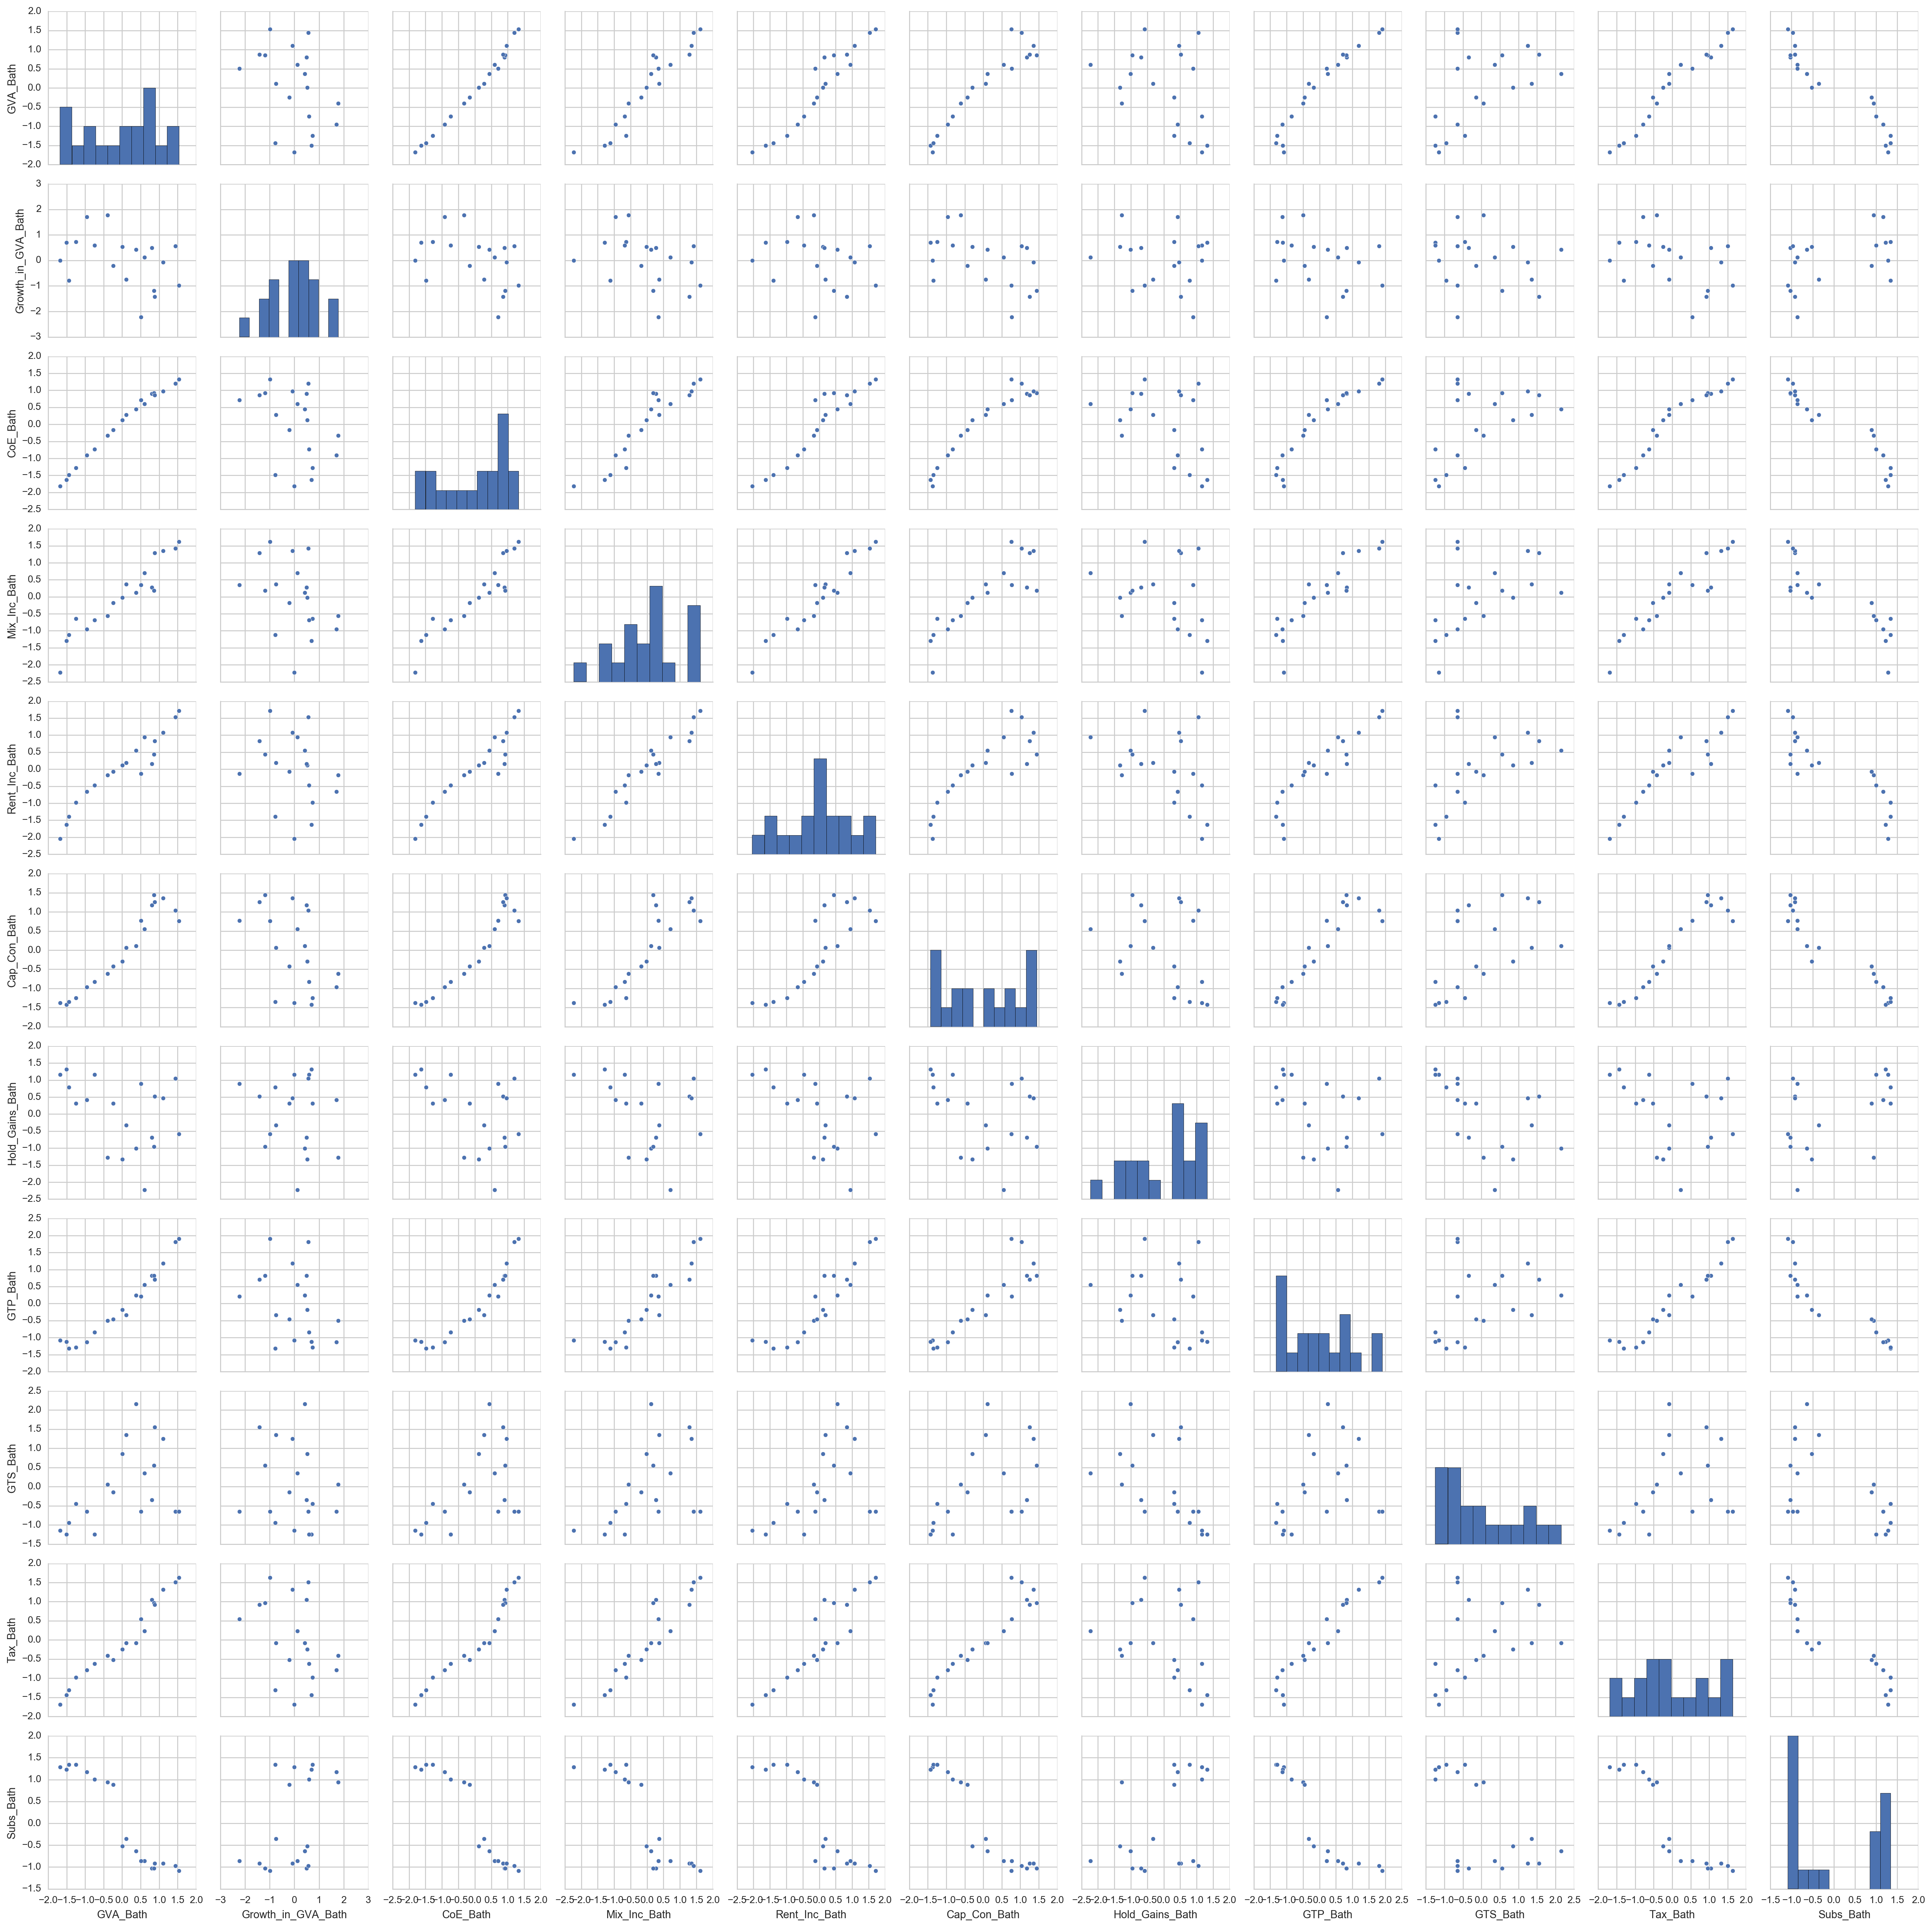

In [247]:
sns.pairplot(stand_data)
plt.show()

Indeed, some features have very strong linear relationship, escpecially CoE & Tax so we need to consider removing them from the set if our model doesn't give us satisfactory results. 